In [5]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import os
import sys
import warnings
from sklearn.exceptions import ConvergenceWarning
# Suppress only the ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def kmeans_clustering(image, k=8):
    """Apply k-means clustering to reduce the image to k colors"""
    # Check if image is grayscale and convert to 3-channel if needed
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        
    # Reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixels = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pixels)
    
    # Replace each pixel value with its nearest cluster center
    centers = kmeans.cluster_centers_.astype(np.uint8)
    labels = kmeans.labels_
    quantized = centers[labels].reshape(image.shape)
    
    return quantized

def canny_edge_detection(image):
    """Apply Canny edge detection to image"""
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
        
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    
    # Convert back to 3-channel for consistent saving
    return cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

def harris_corner_detection(image):
    """Apply Harris corner detection to image"""
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Convert to float32
    gray = np.float32(gray)
    
    # Apply Harris corner detection
    dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
    
    # Dilate result for marking the corners
    dst = cv2.dilate(dst, None)
    
    # Create output image (convert back to 3-channel)
    if len(image.shape) == 3:
        output = image.copy()
    else:
        output = cv2.cvtColor(gray.astype(np.uint8), cv2.COLOR_GRAY2BGR)
        
    # Mark corners with red color
    output[dst > 0.01 * dst.max()] = [0, 0, 255]
    
    return output

def hough_circle_detection(image):
    """Apply Hough circle detection to image"""
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Create output image (convert back to 3-channel)
    if len(image.shape) == 3:
        output = image.copy()
    else:
        output = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    
    # Apply Hough Circle Transform
    # Adjust parameters based on your specific images
    circles = cv2.HoughCircles(
        blurred, 
        cv2.HOUGH_GRADIENT, 
        dp=1, 
        minDist=20,
        param1=50,  # Upper threshold for Canny edge detector
        param2=30,  # Threshold for center detection
        minRadius=0,
        maxRadius=0
    )
    
    # Draw detected circles
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            # Draw outer circle
            cv2.circle(output, (i[0], i[1]), i[2], (0, 255, 0), 2)
            # Draw center
            cv2.circle(output, (i[0], i[1]), 2, (0, 0, 255), 3)
    
    return output

def verify_image_files(input_dir):
    """Verify image files exist and check their properties"""
    print(f"\n--- VERIFYING IMAGE FILES IN: {input_dir} ---")
    
    # Check if directory exists
    if not os.path.exists(input_dir):
        print(f"ERROR: Directory {input_dir} does not exist!")
        return False
    
    # Count files
    all_files = os.listdir(input_dir)
    image_files = [f for f in all_files if f.endswith(('.jpg', '.png'))]
    
    print(f"Total files in directory: {len(all_files)}")
    print(f"Files with .jpg or .png extension: {len(image_files)}")
    
    if not image_files:
        # print("No image files found!")
        return False
    
    # Check first few files
    # print("\nChecking first 3 image files:")
    for i, filename in enumerate(image_files[:3]):
        file_path = os.path.join(input_dir, filename)
        file_size = os.path.getsize(file_path)
        # print(f"  {filename}: Size = {file_size} bytes")
        
       
        
        # Try reading with OpenCV
        img = cv2.imread(file_path)

    
    return True

def process_directory(input_dir, output_dirs, transform_funcs):
    """Process all images in input_dir, applying each transformation and saving to respective output dir"""
    # print(f"Processing directory: {input_dir}")
    
    # Check if input directory exists
    if not os.path.exists(input_dir):
        # print(f"ERROR: Input directory '{input_dir}' does not exist!")
        return False
        
    # Create output directories if they don't exist
    for name, dir_path in output_dirs.items():
        os.makedirs(dir_path, exist_ok=True)
        print(f"Output directory created/confirmed: {dir_path}")
    
    # Count files to process
    image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.png'))]
    total_files = len(image_files)
    print(f"Found {total_files} images to process")
    
    if total_files == 0:
        print("No images found to process!")
        return False
    
    # Process each image
    successes = 0
    failures = 0
    
    for i, filename in enumerate(image_files):
        print(f"[{i+1}/{total_files}] Processing {filename}")
        
        img_path = os.path.join(input_dir, filename)
        file_size = os.path.getsize(img_path)
        
        
        
        img = cv2.imread(img_path)
        if img is None:
            print(f"ERROR: Could not read image: {img_path}")
            failures += 1
            continue
            
        # Apply each transformation and save
        try:
            # First, save the original image
            original_out_path = os.path.join(output_dirs['original'], filename)
            cv2.imwrite(original_out_path, img)
            
            # Now apply each transformation
            for name, transform_func in transform_funcs.items():
                transformed_img = transform_func(img)
                out_path = os.path.join(output_dirs[name], filename)
                cv2.imwrite(out_path, transformed_img)
            
            successes += 1
        except Exception as e:
            # print(f"ERROR processing {filename}: {str(e)}")
            failures += 1
    
    print(f"Finished processing directory: {input_dir}")
    print(f"Summary: {successes} images processed successfully, {failures} failures")
    return True

def main():
    print("Starting transformations for set1...")
    
    # Define base directory
    base_dir = "D:\\Karan Code\\CV_project\\raymond\\src\\data"
    print(f"Base directory: {base_dir}")
    
    # Set1 directory
    set1_dir = os.path.join(base_dir, "set1_duplicate")
    os.makedirs(set1_dir, exist_ok=True)
    
    # Define modalities
    modalities = ['flair', 'segmentation', 't1']
    
    # Define transformation functions
    transform_functions = {
        'canny': canny_edge_detection,
        'harris': harris_corner_detection,
        'hough': hough_circle_detection,
        'kMeans': lambda img: kmeans_clustering(img, k=8)
    }
    
    # Process each modality
    for modality in modalities:
        print(f"\n{'='*80}\nProcessing modality: {modality}\n{'='*80}")
        
        # Set up input directory for this modality
        input_dir = os.path.join(set1_dir, "original", modality)
        
        # Verify input directory before processing
        if not verify_image_files(input_dir):
            print(f"Skipping modality {modality} due to input directory issues.")
            continue
        
        # Set up output directories for this modality
        output_dirs = {
            'original': os.path.join(set1_dir, "original", modality),
            'canny': os.path.join(set1_dir, "canny", modality),
            'harris': os.path.join(set1_dir, "harris", modality),
            'hough': os.path.join(set1_dir, "hough", modality),
            'kMeans': os.path.join(set1_dir, "kMeans", modality),
        }
        
        # Process the images
        success = process_directory(input_dir, output_dirs, transform_functions)
        
        if success:
            print(f"Successfully processed {modality} images")
        else:
            print(f"Failed to process {modality} images")
    
    print("\nAll transformations for set1 complete!")

if __name__ == "__main__":
    main()

Starting transformations for set1...
Base directory: D:\Karan Code\CV_project\raymond\src\data

Processing modality: flair

--- VERIFYING IMAGE FILES IN: D:\Karan Code\CV_project\raymond\src\data\set1_duplicate\original\flair ---
Total files in directory: 2125
Files with .jpg or .png extension: 2125
Output directory created/confirmed: D:\Karan Code\CV_project\raymond\src\data\set1_duplicate\original\flair
Output directory created/confirmed: D:\Karan Code\CV_project\raymond\src\data\set1_duplicate\canny\flair
Output directory created/confirmed: D:\Karan Code\CV_project\raymond\src\data\set1_duplicate\harris\flair
Output directory created/confirmed: D:\Karan Code\CV_project\raymond\src\data\set1_duplicate\hough\flair
Output directory created/confirmed: D:\Karan Code\CV_project\raymond\src\data\set1_duplicate\kMeans\flair
Found 2125 images to process
[1/2125] Processing HG0002-100-True.png
[2/2125] Processing HG0002-101-True.png
[3/2125] Processing HG0002-102-True.png
[4/2125] Processing 

In [8]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import os
import sys

def kmeans_clustering(image, k=8):
    # Reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixels = image.reshape(-1, 3)
    
    # Perform k-means clustering
    # print(f"Performing k-means clustering with k={k}...")
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pixels)
    
    # Replace each pixel value with its nearest cluster center
    centers = kmeans.cluster_centers_.astype(np.uint8)
    labels = kmeans.labels_
    quantized = centers[labels].reshape(image.shape)
    
    return quantized

def verify_image_files(input_dir):
    """Verify image files exist and check their properties"""
    print(f"\n--- VERIFYING IMAGE FILES IN: {input_dir} ---")
    
    # Check if directory exists
    if not os.path.exists(input_dir):
        print(f"ERROR: Directory {input_dir} does not exist!")
        return
    
    # Count files
    all_files = os.listdir(input_dir)
    image_files = [f for f in all_files if f.endswith(('.jpg', '.png'))]
    
    print(f"Total files in directory: {len(all_files)}")
    print(f"Files with .jpg or .png extension: {len(image_files)}")
    
    if not image_files:
        print("No image files found!")
        return
    
    # Check first few files
    # print("\nChecking first 3 image files:")
    for i, filename in enumerate(image_files[:3]):
        file_path = os.path.join(input_dir, filename)
        file_size = os.path.getsize(file_path)
        # print(f"  {filename}: Size = {file_size} bytes")
        
        
       
    import stat
    st_mode = os.stat(input_dir).st_mode
    

def process_directory(input_dir, output_dir, k=8):
    print(f"Processing directory: {input_dir}")
    print(f"Saving results to: {output_dir}")
    
    # Check if input directory exists
   
        
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    print(f"Output directory created/confirmed: {output_dir}")
    
    # Count files to process
    image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.png'))]
    total_files = len(image_files)
    print(f"Found {total_files} images to process")
    
   
    
    # Process each image
    successes = 0
    failures = 0
    
    for i, filename in enumerate(image_files):
        img_path = os.path.join(input_dir, filename)
        file_size = os.path.getsize(img_path)
        print(f"[{i+1}/{total_files}] Processing {img_path} (size: {file_size} bytes)")
        
        
        img = cv2.imread(img_path)
            
        # Apply k-means clustering
        try:
            processed_img = kmeans_clustering(img, k)
            
            # Save the processed image
            out_path = os.path.join(output_dir, filename)
            cv2.imwrite(out_path, processed_img)
            # print(f"Saved processed image to {out_path}")
            successes += 1
        except Exception as e:
            # print(f"ERROR processing {filename}: {str(e)}")
            failures += 1
    
    print(f"Finished processing directory: {input_dir}")
    print(f"Summary: {successes} images processed successfully, {failures} failures")
    return True

def main():
    print("Starting kMeans transformation for set2...")
    
    # Define base directories
    
    # Use a raw string (r prefix) to avoid escape character issues
    base_dir = r"D:\\Karan Code\\CV_project\\raymond\\src\\data"
    print(f"Base directory: {base_dir}")
    
    # Define set2 directory
    set2_dir = os.path.join(base_dir, "set2")
    
    # Verify the directory structure
    print(f"Checking if set2 directory exists: {os.path.exists(set2_dir)}")
    if os.path.exists(set2_dir):
        print(f"Contents of {set2_dir}: {os.listdir(set2_dir)}")
    
    original_dir = os.path.join(set2_dir, "original")
    print(f"Checking if original directory exists: {os.path.exists(original_dir)}")
    if os.path.exists(original_dir):
        print(f"Contents of {original_dir}: {os.listdir(original_dir)}")
    
    # Process each tumor type subdirectory
    tumor_types = ['glioma', 'meningioma', 'notumor', 'pituitary']
    
    for tumor_type in tumor_types:
        input_dir = os.path.join(base_dir, "set2", "original", tumor_type)
        output_dir = os.path.join(base_dir, "set2", "kMeans", tumor_type)
        
        # print(f"\nProcessing tumor type: {tumor_type}")
        
        # Verify input directory before processing
        verify_image_files(input_dir)
        
        success = process_directory(input_dir, output_dir, k=8)
        
        if success:
            print(f"Successfully processed {tumor_type} images")
        else:
            print(f"Failed to process {tumor_type} images")
    
    print("\nkMeans transformation complete!")

if __name__ == "__main__":
    main()

Starting kMeans transformation for set2...
Base directory: D:\\Karan Code\\CV_project\\raymond\\src\\data
Checking if set2 directory exists: True
Contents of D:\\Karan Code\\CV_project\\raymond\\src\\data\set2: ['kMeans', 'original']
Checking if original directory exists: True
Contents of D:\\Karan Code\\CV_project\\raymond\\src\\data\set2\original: ['glioma', 'meningioma', 'notumor', 'pituitary']

--- VERIFYING IMAGE FILES IN: D:\\Karan Code\\CV_project\\raymond\\src\\data\set2\original\glioma ---
Total files in directory: 1321
Files with .jpg or .png extension: 1321
Processing directory: D:\\Karan Code\\CV_project\\raymond\\src\\data\set2\original\glioma
Saving results to: D:\\Karan Code\\CV_project\\raymond\\src\\data\set2\kMeans\glioma
Output directory created/confirmed: D:\\Karan Code\\CV_project\\raymond\\src\\data\set2\kMeans\glioma
Found 1321 images to process
[1/1321] Processing D:\\Karan Code\\CV_project\\raymond\\src\\data\set2\original\glioma\Tr-glTr_0000.jpg (size: 23127 b

Current working directory: d:\Karan Code\CV_project\raymond\src\util
Running with transform type: canny, modality: t1
Dataset path: D:\Karan Code\CV_project\raymond\src\data\set1_duplicate\canny\t1
Dataset prepared path: D:\Karan Code\CV_project\raymond\src\data\set1_duplicate\canny\t1\prepared
Preparing dataset from: D:\Karan Code\CV_project\raymond\src\data\set1_duplicate\canny\t1
Found 2125 images to organize
Organized 1421 tumoral images and 704 healthy images
Loading dataset from D:\Karan Code\CV_project\raymond\src\data\set1_duplicate\canny\t1\prepared
Found 2125 files belonging to 2 classes.
Train with 48 batches + Validate with 13 batches + Test with 6 batches = 67


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 254, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 127, 63, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 125, 61, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 62, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 60, 28, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 30, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 6720)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     1,720,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,730,545 (6.60 MB)

 Trainable params: 1,730,545 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.6639 - loss: 0.6228 - val_accuracy: 0.7067 - val_loss: 0.5403
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.7272 - loss: 0.5136 - val_accuracy: 0.7428 - val_loss: 0.4893
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.7751 - loss: 0.4375 - val_accuracy: 0.7260 - val_loss: 0.5207
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.8091 - loss: 0.3990 - val_accuracy: 0.7644 - val_loss: 0.4481
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.8205 - loss: 0.3769 - val_accuracy: 0.8029 - val_loss: 0.4462
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.8569 - loss: 0.3166 - val_accuracy: 0.8053 - val_loss: 0.4281
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.8692 - loss: 0.2826 - val_accuracy: 0.8101 - val_loss: 0.4367
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9012 - loss: 0.2331 - val_accurac

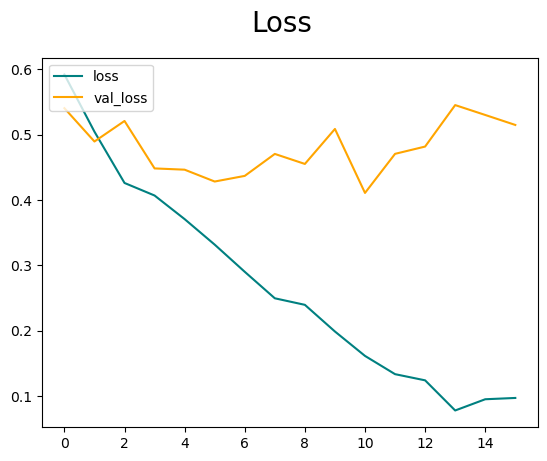

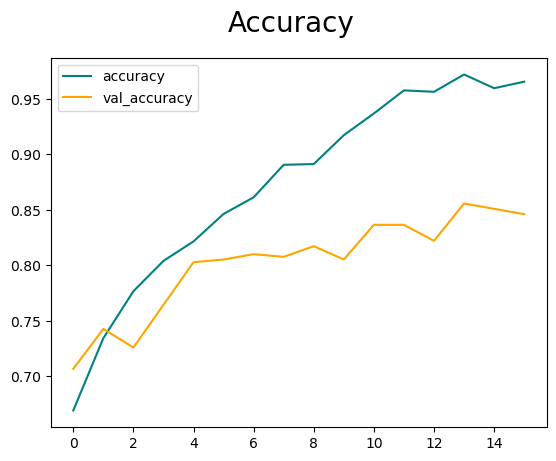

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Precision: 0.9158878326416016, Recall: 0.8235294222831726, BinaryAccuracy: 0.8265895843505859
Your dataset came from D:\Karan Code\CV_project\raymond\src\data\set1_duplicate\canny\t1
Would you like to save the model? (y/n)
What would you like to name the model?


Model saved to d:\Karan Code\CV_project\raymond\src\util\models\t1-set1-canny-0.96-lofp.h5


In [9]:
import tensorflow as tf
import cv2 as cv
import os
import numpy as np
import shutil
from matplotlib import pyplot as plt

BASE_DIR = r"D:\Karan Code\CV_project\raymond\src\data"
SET1_DIR = os.path.join(BASE_DIR, "set1_duplicate")  # Using the directory created by tranform.py

# True or 1= Has Tumor
# False or 0= No Tumor
TRANSFORM_TYPE = "canny"  # One of: original, canny, harris, hough, kMeans
MODALITY = "t1"  # One of: flair, segmentation, t1

# Build the dataset path
DATASET_PATH = os.path.join(SET1_DIR, TRANSFORM_TYPE, MODALITY)
DATASET_PREPARED_PATH = os.path.join(DATASET_PATH, "prepared")
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 128

# prevent OOM errors
def gpu_settings() -> None:
    """Sets GPU memory growth to prevent OOM errors"""
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

def prepare_dataset() -> bool:
    """Prepares the dataset by organizing images into tumoral and healthy subdirectories"""
    print(f"Preparing dataset from: {DATASET_PATH}")
    
    # Check if source directory exists
    if not os.path.exists(DATASET_PATH):
        print(f"ERROR: Dataset source directory not found: {DATASET_PATH}")
        print(f"Please check if you have run transform.py correctly to generate this directory")
        print(f"Looking for available directories:")
        
        # Check what directories are available
        if os.path.exists(SET1_DIR):
            print(f"Found {SET1_DIR} with subdirectories:")
            for item in os.listdir(SET1_DIR):
                if os.path.isdir(os.path.join(SET1_DIR, item)):
                    print(f"  - {item}")
                    if item == TRANSFORM_TYPE:
                        transform_path = os.path.join(SET1_DIR, item)
                        print(f"    Contains subdirectories:")
                        for subitem in os.listdir(transform_path):
                            print(f"      - {subitem}")
        else:
            print(f"SET1_DIR not found: {SET1_DIR}")
            print("Please run transform.py first to generate the dataset")
        
        return False
    
    # Create prepared dataset directory with class subdirectories
    os.makedirs(os.path.join(DATASET_PREPARED_PATH, "tumoral"), exist_ok=True)
    os.makedirs(os.path.join(DATASET_PREPARED_PATH, "healthy"), exist_ok=True)
    
    # Count files to process
    image_files = [f for f in os.listdir(DATASET_PATH) if f.endswith(('.jpg', '.png'))]
    total_files = len(image_files)
    print(f"Found {total_files} images to organize")
    
    if total_files == 0:
        print("No images found to process!")
        return False
    
    # Organize images into class subdirectories
    tumoral_count = 0
    healthy_count = 0
    
    for filename in image_files:
        src_path = os.path.join(DATASET_PATH, filename)
        
        # Skip directories
        if os.path.isdir(src_path):
            continue
        
        # Determine class based on filename
        if 'True' in filename:
            dest_dir = os.path.join(DATASET_PREPARED_PATH, "tumoral")
            tumoral_count += 1
        elif 'False' in filename:
            dest_dir = os.path.join(DATASET_PREPARED_PATH, "healthy")
            healthy_count += 1
        else:
            print(f"WARNING: Could not determine class for {filename}, skipping")
            continue
        
        # Copy file to class subdirectory
        dest_path = os.path.join(dest_dir, filename)
        shutil.copy2(src_path, dest_path)
    
    print(f"Organized {tumoral_count} tumoral images and {healthy_count} healthy images")
    return True

# load data from directory as a tensor dataset
def load_data() -> tf.data.Dataset:
    """Load data from the prepared dataset directory"""
    # First make sure the dataset is prepared
    if not prepare_dataset():
        raise FileNotFoundError(f"Could not prepare dataset from {DATASET_PATH}")
    
    # TODO: Change to allow for all 3 modalities
    # TODO: Experiment with Different batch_sizes
    print(f"Loading dataset from {DATASET_PREPARED_PATH}")
    data = tf.keras.utils.image_dataset_from_directory(
        DATASET_PREPARED_PATH, 
        image_size=(IMAGE_HEIGHT, IMAGE_WIDTH), 
        batch_size=32,
        seed=42
    )

    # Scaling Data to speed up ML process
    scaled = data.map(lambda x, y: (x/255, y))
    
    return scaled

# split data into train, validation, and test sets (70%, 20%, 10%)
def split_data(data: tf.data.Dataset) -> tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    # TODO: Play around with the split percentages
    val_size = int(len(data)*.2)
    test_size = int(len(data)*.1)
    train_size = len(data) - val_size - test_size
    print(
        f'Train with {train_size} batches + Validate with {val_size} batches + Test with {test_size} batches = {len(data)}')

    train = data.take(train_size)
    val = data.skip(train_size).take(val_size)
    test = data.skip(train_size+val_size).take(test_size)

    return train, val, test


# NOTE: This is where all the fun is :)
def build_cnn_model() -> tf.keras.models.Sequential:
    model = tf.keras.models.Sequential()

    # TODO: Experiment with different layers and parameters
    Conv2D = tf.keras.layers.Conv2D
    MaxPooling2D = tf.keras.layers.MaxPooling2D
    Flatten = tf.keras.layers.Flatten
    Dense = tf.keras.layers.Dense

    # ----------------- 1st Convolutional Layer -----------------
    model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(MaxPooling2D())

    # ----------------- 2nd Convolutional Layer -----------------
    model.add(Conv2D(32, (3, 3), 1, activation='relu'))
    model.add(MaxPooling2D())

    # ----------------- 3rd Convolutional Layer -----------------
    model.add(Conv2D(16, (3, 3), 1, activation='relu'))
    model.add(MaxPooling2D())
    
    # ----------------- 4th Convolutional Layer -----------------
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile('adam', loss=tf.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    print(model.summary())
    return model


def train_model(model: tf.keras.models.Sequential, train: tf.data.Dataset, val: tf.data.Dataset) -> tuple[tf.keras.models.Sequential, tf.keras.callbacks.History]:
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True) # Used to prevent overfitting

    # TODO: Experiment with different epochs
    hist = model.fit(train, validation_data=val, epochs=30, callbacks=[early_stopping])
    return model, hist


def plot_model_performance(hist: tf.keras.callbacks.History) -> None:
    loss = plt.figure()
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    loss.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")

    accuracy = plt.figure()
    plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
    plt.plot(hist.history['val_accuracy'],
             color='orange', label='val_accuracy')
    accuracy.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()


def evaluate_model(model: tf.keras.models.Sequential, test: tf.data.Dataset) -> None:
    # TODO: Try Different Metrics
    pre = tf.keras.metrics.Precision()
    re = tf.keras.metrics.Recall()
    acc = tf.keras.metrics.BinaryAccuracy()

    for batch in test.as_numpy_iterator():
        X, y = batch
        yhat = model.predict(X)
        pre.update_state(y, yhat)
        re.update_state(y, yhat)
        acc.update_state(y, yhat)

    print(f'Precision: {pre.result()}, Recall: {re.result()}, BinaryAccuracy: {acc.result()}')


def save_model(model: tf.keras.models.Sequential) -> None:
    # Create models directory if it doesn't exist
    # Define the base path explicitly for your notebook
    notebook_dir = os.path.abspath('.')
    model_dir = os.path.join(notebook_dir, 'models')
    os.makedirs(model_dir, exist_ok=True)
    
    print(f'Your dataset came from {DATASET_PATH}')
    print('Would you like to save the model? (y/n)')
    while True:
        inp = input()
        if inp == 'y':
            print('What would you like to name the model?')
            model_name = input()
            model_path = os.path.join(model_dir, f'{model_name}.h5')
            model.save(model_path)
            print(f"Model saved to {model_path}")
            break
        if inp == 'n':
            break


def main():
    print(f"Current working directory: {os.getcwd()}")
    print(f"Running with transform type: {TRANSFORM_TYPE}, modality: {MODALITY}")
    print(f"Dataset path: {DATASET_PATH}")
    print(f"Dataset prepared path: {DATASET_PREPARED_PATH}")
    
    # Set GPU memory growth to prevent OOM errors
    gpu_settings()

    try:
        data = load_data()
        train, val, test = split_data(data)

        model, hist = train_model(build_cnn_model(), train, val)

        plot_model_performance(hist)

        evaluate_model(model, test)

        save_model(model)
        
    except FileNotFoundError as e:
        print(f"ERROR: {str(e)}")
        print("Make sure you have run transform.py to generate the dataset")
        print(f"Expected dataset path: {DATASET_PATH}")
        return
    except Exception as e:
        print(f"Unexpected error: {str(e)}")
        return

if __name__ == '__main__':
    main()

In [3]:
import tensorflow as tf
import cv2 as cv
import os
import numpy as np
from matplotlib import pyplot as plt
import time

# 0 = Giloma
# 1 = Meningioma
# 2 = Healthy (notumor)
# 3 = Pituitary

# Define paths - FIXED to use proper nested directory structure
BASE_DIR = r"D:\Karan Code\CV_project\raymond\src\data"
SET2_DIR = os.path.join(BASE_DIR, "set2")
TRANSFORM_TYPE = "kMeans"  # Choose "original" or "kMeans"
DATASET_PATH = os.path.join(SET2_DIR, TRANSFORM_TYPE)  # Now points to set2/original or set2/kMeans
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

def gpu_settings() -> None:
    """Sets GPU memory growth to prevent OOM errors"""
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

def load_data() -> tuple[tf.data.Dataset, list]:
    # First check what subdirectories exist in the dataset path
    print(f"Checking subdirectories in {DATASET_PATH}:")
    
    if not os.path.exists(DATASET_PATH):
        print(f"ERROR: Dataset path {DATASET_PATH} not found!")
        print(f"Available paths:")
        if os.path.exists(SET2_DIR):
            print(f"- Subdirectories in {SET2_DIR}:")
            for dir in os.listdir(SET2_DIR):
                print(f"  - {dir}")
        raise FileNotFoundError(f"Dataset path {DATASET_PATH} not found")
    
    subdirs = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
    print(f"Found subdirectories: {subdirs}")
    
    # These should be the class directories (glioma, meningioma, notumor, pituitary)
    expected_classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
    found_classes = [d.lower() for d in subdirs]
    
    print(f"Expected classes: {expected_classes}")
    print(f"Found classes: {found_classes}")
    
    data = tf.keras.utils.image_dataset_from_directory(
        DATASET_PATH, image_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=32, label_mode='categorical')
    
    # Save the class names before mapping
    class_names = data.class_names
    
    # Print class names from the dataset
    print(f"Dataset class names: {class_names}")
    print(f"Number of classes: {len(class_names)}")
    
    # Scaling Data to speed up ML process
    scaled = data.map(lambda x, y: (x/255, y))
    
    # Return both the scaled dataset and the class names
    return scaled, class_names

def split_data(data: tf.data.Dataset) -> tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    # split data into train, validation, and test sets (70%, 20%, 10%)
    val_size = int(len(data)*.2)
    test_size = int(len(data)*.1)
    train_size = len(data) - val_size - test_size
    print(
        f'Train with {train_size} batches + Validate with {val_size} batches + Test with {test_size} batches = {len(data)}')

    train = data.take(train_size)
    val = data.skip(train_size).take(val_size)
    test = data.skip(train_size+val_size).take(test_size)

    return train, val, test

def build_cnn_model(num_classes) -> tf.keras.Model:
    """Build a CNN model with the correct number of output classes"""
    model = tf.keras.models.Sequential()

    # Define layer types first
    Conv2D = tf.keras.layers.Conv2D
    MaxPooling2D = tf.keras.layers.MaxPooling2D
    Flatten = tf.keras.layers.Flatten
    Dense = tf.keras.layers.Dense

    # ----------------- 1st Convolutional Layer -----------------
    model.add(Conv2D(64, (3, 3), 1, activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(MaxPooling2D())

    # ----------------- 2nd Convolutional Layer -----------------
    model.add(Conv2D(32, (3, 3), 1, activation='relu'))
    model.add(MaxPooling2D())

    # ----------------- 3rd Convolutional Layer -----------------
    model.add(Conv2D(16, (3, 3), 1, activation='relu'))
    model.add(MaxPooling2D())

    # ----------------- 4th Convolutional Layer -----------------
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    # Use the correct number of outputs based on the actual number of classes
    model.add(Dense(num_classes, activation='softmax'))

    # compile model with adam optimizer and categorical crossentropy loss
    model.compile('adam', loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

    print(model.summary())
    return model

def train_model(model: tf.keras.models.Sequential, train: tf.data.Dataset, val: tf.data.Dataset) -> tuple[tf.keras.models.Sequential, tf.keras.callbacks.History]:
    # early stopping to prevent overfitting and save best model
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    
    hist = model.fit(train, validation_data=val, epochs=30, callbacks=[early_stop])
    return model, hist

def plot_model_performance(hist: tf.keras.callbacks.History) -> None:
    # Create plots directory if it doesn't exist
    notebook_dir = os.getcwd() 
    plots_dir = os.path.join(notebook_dir, 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    
    # Generate timestamp for unique filenames
    timestamp = int(time.time())
    
    # Create loss plot
    loss = plt.figure()
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    loss.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    loss_filename = os.path.join(plots_dir, f'set2_{TRANSFORM_TYPE}_loss_{timestamp}.png')
    loss.savefig(loss_filename)
    plt.close(loss)
    print(f"Loss plot saved to {loss_filename}")
    
    # Create accuracy plot
    accuracy = plt.figure()
    plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
    accuracy.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    accuracy_filename = os.path.join(plots_dir, f'set2_{TRANSFORM_TYPE}_accuracy_{timestamp}.png')
    accuracy.savefig(accuracy_filename)
    plt.close(accuracy)
    print(f"Accuracy plot saved to {accuracy_filename}")

def evaluate_model(model: tf.keras.models.Sequential, test: tf.data.Dataset) -> None:
    pre = tf.keras.metrics.Precision()
    re = tf.keras.metrics.Recall()
    acc = tf.keras.metrics.CategoricalAccuracy()

    print("Evaluating model on test data...")
    for batch in test.as_numpy_iterator():
        X, y = batch
        yhat = model.predict(X, verbose=0)
        pre.update_state(y, yhat)
        re.update_state(y, yhat)
        acc.update_state(y, yhat)

    print(f'Precision: {pre.result()}, Recall: {re.result()}, CategoricalAccuracy: {acc.result()}')

def save_model(model: tf.keras.models.Sequential) -> None:
    # Create models directory if it doesn't exist
    notebook_dir = os.path.abspath('.')
    model_dir = os.path.join(notebook_dir, 'models')
    os.makedirs(model_dir, exist_ok=True)
    
    print(f'Your dataset came from {DATASET_PATH}')
    print('Would you like to save the model? (y/n)')
    while True:
        inp = input()
        if inp == 'y':
            print('What would you like to name the model?')
            model_name = input()
            model_path = os.path.join(model_dir, f'{model_name}.h5')
            model.save(model_path)
            print(f"Model saved to {model_path}")
            break
        if inp == 'n':
            break

def main():
    print(f"Starting multi-class brain tumor classification training...")
    print(f"Using transform type: {TRANSFORM_TYPE}")
    print(f"Dataset path: {DATASET_PATH}")
    
    # Set GPU memory growth to prevent OOM errors
    gpu_settings()

    try:
        # Load and prepare dataset - now returns dataset and class names separately
        data, class_names = load_data()
        
        # Get number of classes from the class_names list
        num_classes = len(class_names)
        print(f"Building model for {num_classes} classes: {class_names}")
        
        # Split data
        train, val, test = split_data(data)
        
        # Build and train model with the correct number of output classes
        model, hist = train_model(build_cnn_model(num_classes), train, val)
        
        # Plot performance metrics
        plot_model_performance(hist)
        
        # Evaluate model on test set
        evaluate_model(model, test)
        
        # Save the model
        save_model(model)
        
    except Exception as e:
        print(f"ERROR: {str(e)}")
        import traceback
        traceback.print_exc()
        return

if __name__ == "__main__":
    import time  # Import time for timestamps
    main()

Starting multi-class brain tumor classification training...
Using transform type: kMeans
Dataset path: D:\Karan Code\CV_project\raymond\src\data\set2\kMeans
Checking subdirectories in D:\Karan Code\CV_project\raymond\src\data\set2\kMeans:
Found subdirectories: ['glioma', 'meningioma', 'notumor', 'pituitary']
Expected classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Found classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Found 5712 files belonging to 4 classes.
Dataset class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of classes: 4
Building model for 4 classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Train with 127 batches + Validate with 35 batches + Test with 17 batches = 179


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,712,564 (14.16 MB)

 Trainable params: 3,712,564 (14.16 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.5980 - loss: 0.9491 - val_accuracy: 0.8098 - val_loss: 0.5042
Epoch 2/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 111s 869ms/step - accuracy: 0.8589 - loss: 0.3959 - val_accuracy: 0.8813 - val_loss: 0.3497
Epoch 3/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 115s 905ms/step - accuracy: 0.9037 - loss: 0.2605 - val_accuracy: 0.9080 - val_loss: 0.2676
Epoch 4/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 113s 886ms/step - accuracy: 0.9473 - loss: 0.1494 - val_accuracy: 0.8723 - val_loss: 0.3567
Epoch 5/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 110s 864ms/step - accuracy: 0.9693 - loss: 0.0857 - val_accuracy: 0.9143 - val_loss: 0.2707
Epoch 6/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 109s 853ms/step - accuracy: 0.9722 - loss: 0.0664 - val_accuracy: 0.9080 - val_loss: 0.4057
Epoch 7/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 108s 850ms/step - accuracy: 0.9881 - loss: 0.0354 - val_accuracy: 0.9125 - val_loss: 0.2966
Epoch 8/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 109s 859ms/step - accuracy: 0.9827

Model saved to d:\Karan Code\CV_project\raymond\src\util\models\kmeans_set2.h5


Brain Tumor Classification Prediction Tool



Using the following parameters:
Dataset type: set2
Model file: set2-original-0.91-lofp.h5
Image file: D:\Karan Code\CV_project\raymond\src\util\tests\kMeans-set2-glioma-Te-gl_0025.jpg
Using image at: D:\Karan Code\CV_project\raymond\src\util\tests\kMeans-set2-glioma-Te-gl_0025.jpg
Loading model: d:\Karan Code\CV_project\raymond\src\util\models\set2-original-0.91-lofp.h5
Loading image: D:\Karan Code\CV_project\raymond\src\util\tests\kMeans-set2-glioma-Te-gl_0025.jpg
Image shape: (512, 512, 3), dtype: uint8
Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Prediction: Glioma (Confidence: 0.76)
Result image saved to: d:\Karan Code\CV_project\raymond\src\util\results\result_kMeans-set2-glioma-Te-gl_0025.jpg


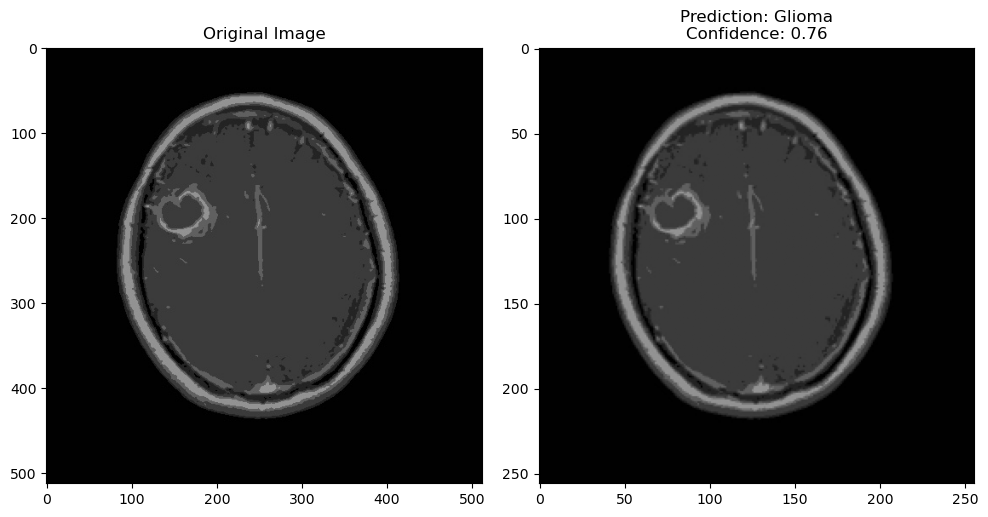

In [6]:
import tensorflow as tf
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Constants for binary classification (set1)
IMAGE_HEIGHT_BINARY = 256
IMAGE_WIDTH_BINARY = 128

# Constants for multiclass classification (set2)
IMAGE_HEIGHT_MULTI = 256
IMAGE_WIDTH_MULTI = 256

def predict_image():
    # Instead of command line arguments, get inputs interactively
    print("Brain Tumor Classification Prediction Tool")
    print("=========================================")
    
    # Get dataset type
    while True:
        dataset_type = input("Enter dataset type (set1 or set2): ").strip().lower()
        if dataset_type in ['set1', 'set2']:
            break
        print("Error: Please enter 'set1' or 'set2'")
    
    # Get model file
    model_file = input("Enter model filename (e.g., 'set2-kMeans-0.90-lofp.h5'): ").strip()
    
    # Get image file
    image_file = input("Enter image filename or full path: ").strip()
    
    # Print the inputs for verification
    print("\nUsing the following parameters:")
    print(f"Dataset type: {dataset_type}")
    print(f"Model file: {model_file}")
    print(f"Image file: {image_file}")
    
    # Build file paths
    notebook_dir = os.getcwd()
    model_path = os.path.join(notebook_dir, 'models', model_file)
    
    # Check image path - try multiple locations
    possible_image_paths = [
        image_file,  # Full path provided
        os.path.join(notebook_dir, 'tests', image_file),  # In tests directory
        os.path.join(notebook_dir, image_file),  # Current working directory
        os.path.join(notebook_dir, 'images', image_file)  # In images directory
    ]
    
    image_path = None
    for path in possible_image_paths:
        if os.path.exists(path):
            image_path = path
            break
    
    # Check if files exist
    if not os.path.exists(model_path):
        print(f"Error: Model file not found: {model_path}")
        print(f"Available models:")
        models_dir = os.path.join(notebook_dir, 'models')
        if os.path.exists(models_dir):
            models = [file for file in os.listdir(models_dir) if file.endswith('.h5')]
            if models:
                for file in models:
                    print(f"  - {file}")
            else:
                print("  No .h5 model files found")
        return
    
    if image_path is None:
        print(f"Error: Image file not found: {image_file}")
        print(f"Checked the following locations:")
        for path in possible_image_paths:
            print(f"  - {path}")
        return
    
    print(f"Using image at: {image_path}")
    
    # Load the model
    print(f"Loading model: {model_path}")
    model = tf.keras.models.load_model(model_path)
    
    # Load and preprocess the image
    print(f"Loading image: {image_path}")
    img = cv2.imread(image_path)
    
    if img is None:
        print(f"Error: Failed to load image: {image_path}")
        print("This could be due to:")
        print("  - The file exists but is not a valid image")
        print("  - The file path contains special characters")
        print("  - File permissions issues")
        return
    
    # Show image details for debugging
    print(f"Image shape: {img.shape}, dtype: {img.dtype}")
    
    # Convert from BGR to RGB (OpenCV loads as BGR, TensorFlow expects RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize image based on dataset type
    if dataset_type == 'set1':
        resize = tf.image.resize(img, (IMAGE_HEIGHT_BINARY, IMAGE_WIDTH_BINARY))
    else:  # set2
        resize = tf.image.resize(img, (IMAGE_HEIGHT_MULTI, IMAGE_WIDTH_MULTI))
    
    # Normalize image
    resize = resize / 255.0
    
    # Add batch dimension
    image_tensor = tf.expand_dims(resize, 0)
    
    # Make prediction
    print("Making prediction...")
    predictions = model.predict(image_tensor)
    
    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    
    plt.subplot(1, 2, 2)
    
    if dataset_type == 'set1':
        # Binary classification
        prediction = predictions[0][0]
        class_name = "Tumor" if prediction > 0.5 else "No Tumor"
        confidence = prediction if prediction > 0.5 else 1 - prediction
        
        plt.imshow(resize.numpy())
        plt.title(f"Prediction: {class_name}\nConfidence: {confidence:.2f}")
        
        print(f"Prediction: {class_name} (Confidence: {confidence:.2f})")
    else:
        # Multi-class classification
        prediction = np.argmax(predictions[0])
        class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
        confidence = predictions[0][prediction]
        
        plt.imshow(resize.numpy())
        plt.title(f"Prediction: {class_names[prediction]}\nConfidence: {confidence:.2f}")
        
        print(f"Prediction: {class_names[prediction]} (Confidence: {confidence:.2f})")
    
    # Save result image
    results_dir = os.path.join(notebook_dir, 'results')
    os.makedirs(results_dir, exist_ok=True)
    result_filename = f"result_{os.path.basename(image_path)}"
    result_path = os.path.join(results_dir, result_filename)
    plt.tight_layout()
    plt.savefig(result_path)
    print(f"Result image saved to: {result_path}")
    
    # Show the plot
    plt.show()

# Execute the function when run in Jupyter
predict_image()

Brain Tumor Classification Prediction Tool



Using the following parameters:
Dataset type: set1
Model file: segmentation-set1-harris-0.93-lofp.h5
Image file: D:\Karan Code\CV_project\raymond\src\util\tests\harris-set1-t1-HG0001-85-True.png
Using image at: D:\Karan Code\CV_project\raymond\src\util\tests\harris-set1-t1-HG0001-85-True.png
Loading model: d:\Karan Code\CV_project\raymond\src\util\models\segmentation-set1-harris-0.93-lofp.h5
Loading image: D:\Karan Code\CV_project\raymond\src\util\tests\harris-set1-t1-HG0001-85-True.png
Image shape: (256, 128, 3), dtype: uint8
Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Prediction: Tumor (Confidence: 1.00)
Result image saved to: d:\Karan Code\CV_project\raymond\src\util\results\result_harris-set1-t1-HG0001-85-True.png


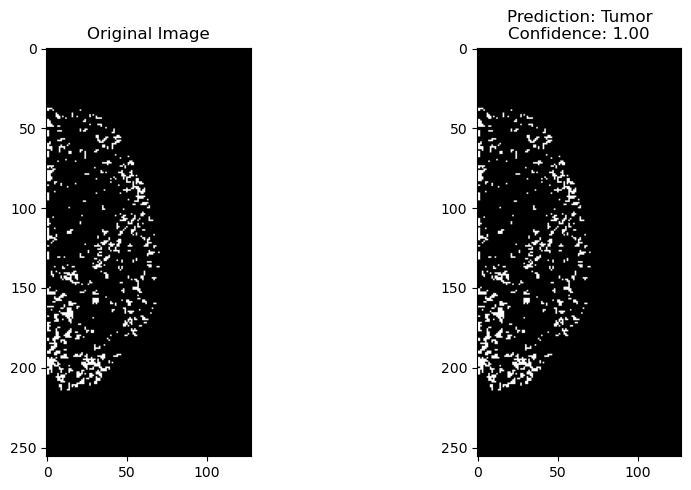

In [7]:
import tensorflow as tf
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Constants for binary classification (set1)
IMAGE_HEIGHT_BINARY = 256
IMAGE_WIDTH_BINARY = 128

# Constants for multiclass classification (set2)
IMAGE_HEIGHT_MULTI = 256
IMAGE_WIDTH_MULTI = 256

def predict_image():
    # Instead of command line arguments, get inputs interactively
    print("Brain Tumor Classification Prediction Tool")
    print("=========================================")
    
    # Get dataset type
    while True:
        dataset_type = input("Enter dataset type (set1 or set2): ").strip().lower()
        if dataset_type in ['set1', 'set2']:
            break
        print("Error: Please enter 'set1' or 'set2'")
    
    # Get model file
    model_file = input("Enter model filename (e.g., 'set2-kMeans-0.90-lofp.h5'): ").strip()
    
    # Get image file
    image_file = input("Enter image filename or full path: ").strip()
    
    # Print the inputs for verification
    print("\nUsing the following parameters:")
    print(f"Dataset type: {dataset_type}")
    print(f"Model file: {model_file}")
    print(f"Image file: {image_file}")
    
    # Build file paths
    notebook_dir = os.getcwd()
    model_path = os.path.join(notebook_dir, 'models', model_file)
    
    # Check image path - try multiple locations
    possible_image_paths = [
        image_file,  # Full path provided
        os.path.join(notebook_dir, 'tests', image_file),  # In tests directory
        os.path.join(notebook_dir, image_file),  # Current working directory
        os.path.join(notebook_dir, 'images', image_file)  # In images directory
    ]
    
    image_path = None
    for path in possible_image_paths:
        if os.path.exists(path):
            image_path = path
            break
    
    # Check if files exist
    if not os.path.exists(model_path):
        print(f"Error: Model file not found: {model_path}")
        print(f"Available models:")
        models_dir = os.path.join(notebook_dir, 'models')
        if os.path.exists(models_dir):
            models = [file for file in os.listdir(models_dir) if file.endswith('.h5')]
            if models:
                for file in models:
                    print(f"  - {file}")
            else:
                print("  No .h5 model files found")
        return
    
    if image_path is None:
        print(f"Error: Image file not found: {image_file}")
        print(f"Checked the following locations:")
        for path in possible_image_paths:
            print(f"  - {path}")
        return
    
    print(f"Using image at: {image_path}")
    
    # Load the model
    print(f"Loading model: {model_path}")
    model = tf.keras.models.load_model(model_path)
    
    # Load and preprocess the image
    print(f"Loading image: {image_path}")
    img = cv2.imread(image_path)
    
    if img is None:
        print(f"Error: Failed to load image: {image_path}")
        print("This could be due to:")
        print("  - The file exists but is not a valid image")
        print("  - The file path contains special characters")
        print("  - File permissions issues")
        return
    
    # Show image details for debugging
    print(f"Image shape: {img.shape}, dtype: {img.dtype}")
    
    # Convert from BGR to RGB (OpenCV loads as BGR, TensorFlow expects RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize image based on dataset type
    if dataset_type == 'set1':
        resize = tf.image.resize(img, (IMAGE_HEIGHT_BINARY, IMAGE_WIDTH_BINARY))
    else:  # set2
        resize = tf.image.resize(img, (IMAGE_HEIGHT_MULTI, IMAGE_WIDTH_MULTI))
    
    # Normalize image
    resize = resize / 255.0
    
    # Add batch dimension
    image_tensor = tf.expand_dims(resize, 0)
    
    # Make prediction
    print("Making prediction...")
    predictions = model.predict(image_tensor)
    
    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    
    plt.subplot(1, 2, 2)
    
    if dataset_type == 'set1':
        # Binary classification
        prediction = predictions[0][0]
        class_name = "Tumor" if prediction > 0.5 else "No Tumor"
        confidence = prediction if prediction > 0.5 else 1 - prediction
        
        plt.imshow(resize.numpy())
        plt.title(f"Prediction: {class_name}\nConfidence: {confidence:.2f}")
        
        print(f"Prediction: {class_name} (Confidence: {confidence:.2f})")
    else:
        # Multi-class classification
        prediction = np.argmax(predictions[0])
        class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
        confidence = predictions[0][prediction]
        
        plt.imshow(resize.numpy())
        plt.title(f"Prediction: {class_names[prediction]}\nConfidence: {confidence:.2f}")
        
        print(f"Prediction: {class_names[prediction]} (Confidence: {confidence:.2f})")
    
    # Save result image
    results_dir = os.path.join(notebook_dir, 'results')
    os.makedirs(results_dir, exist_ok=True)
    result_filename = f"result_{os.path.basename(image_path)}"
    result_path = os.path.join(results_dir, result_filename)
    plt.tight_layout()
    plt.savefig(result_path)
    print(f"Result image saved to: {result_path}")
    
    # Show the plot
    plt.show()

# Execute the function when run in Jupyter
predict_image()